In [2]:
from nilmtk import DataSet

# Replace with the actual path where you extracted ukdale.h5
dataset = DataSet('D:/lusip/ukdale.h5/ukdale.h5')


In [3]:
# Show the buildings available in the dataset
print("Available buildings:", dataset.buildings)


Available buildings: OrderedDict({1: Building(instance=1, dataset='UK-DALE'), 2: Building(instance=2, dataset='UK-DALE'), 3: Building(instance=3, dataset='UK-DALE'), 4: Building(instance=4, dataset='UK-DALE'), 5: Building(instance=5, dataset='UK-DALE')})


In [4]:
# Get electricity data for Building 1
elec = dataset.buildings[1].elec

# Show all appliances in the building
print("Appliances in Building 1:")
print(elec.appliances)


Appliances in Building 1:
[Appliance(type='light', instance=11), Appliance(type='kitchen aid', instance=1), Appliance(type='light', instance=8), Appliance(type='light', instance=14), Appliance(type='television', instance=1), Appliance(type='water pump', instance=1), Appliance(type='oven', instance=1), Appliance(type='boiler', instance=1), Appliance(type='washer dryer', instance=1), Appliance(type='fan', instance=1), Appliance(type='laptop computer', instance=2), Appliance(type='computer', instance=1), Appliance(type='food processor', instance=2), Appliance(type='mobile phone charger', instance=1), Appliance(type='broadband router', instance=1), Appliance(type='vacuum cleaner', instance=1), Appliance(type='baby monitor', instance=1), Appliance(type='toasted sandwich maker', instance=1), Appliance(type='kettle', instance=1), Appliance(type='radio', instance=2), Appliance(type='HTPC', instance=1), Appliance(type='tablet computer charger', instance=1), Appliance(type='security alarm', inst

c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:509: UserWarning: Found duplicate index. Keeping first value
  warnings.warn("Found duplicate index. Keeping first value")
c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


<Axes: >

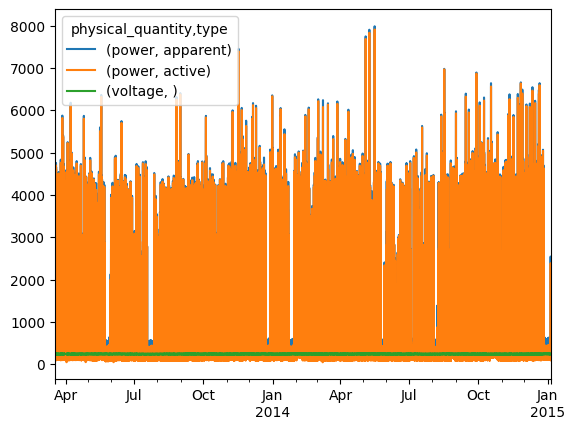

In [5]:
# Load mains power with a sample period (e.g., 6 seconds)
mains_df = next(elec.mains().load(sample_period=6))
# Now plot the loaded DataFrame
mains_df.plot()


c:\Users\tanmay\AppData\Local\Programs\Python\Python313\Lib\site-packages\nilmtk\utils.py:501: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  return fill_method(how(data.resample(rule, **resample_kwargs)))


<Axes: >

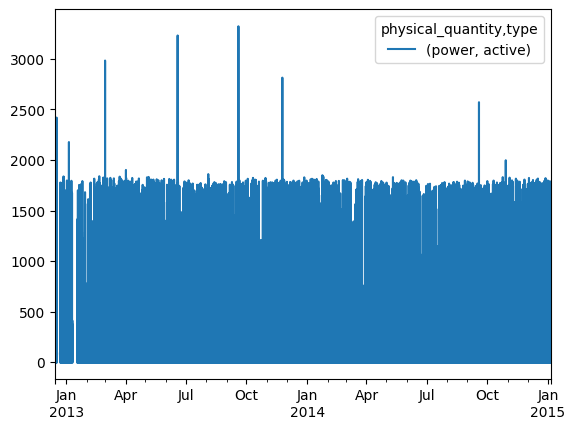

In [6]:
# Load fridge power data with same sample period
fridge_df = next(elec['fridge'].load(sample_period=6))

# Plot to visualize
fridge_df.plot()


In [ ]:
# Keep only active power for mains
mains_df = mains_df[('power', 'active')].to_frame()
mains_df.columns = ['mains']  # Rename for simplicity

# Keep only active power for fridge
fridge_df = fridge_df[('power', 'active')].to_frame()
fridge_df.columns = ['fridge']

In [8]:
# Align timestamps by inner join
aligned_df = mains_df.join(fridge_df, how='inner')

# Drop NaN rows just in case
aligned_df.dropna(inplace=True)
aligned_df = aligned_df[aligned_df['fridge'] <= 200]
# Check result
print(aligned_df.head())


                                mains  fridge
2013-03-17 19:12:42+00:00  339.523987    87.0
2013-03-17 19:12:48+00:00  339.588348    88.0
2013-03-17 19:12:54+00:00  339.195007    88.0
2013-03-17 19:13:00+00:00  339.511688    88.0
2013-03-17 19:13:06+00:00  339.971649    88.0


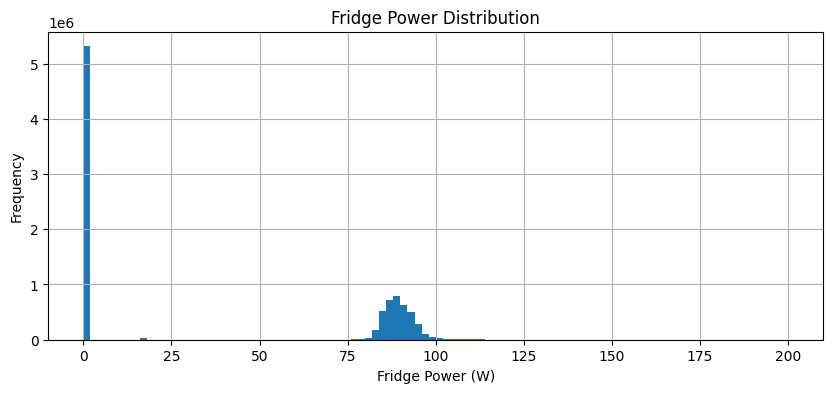

In [9]:
import matplotlib.pyplot as plt

aligned_df['fridge'].plot(kind='hist', bins=100, figsize=(10, 4), title='Fridge Power Distribution')
plt.xlabel('Fridge Power (W)')
plt.grid(True)
plt.show()


In [10]:
print("Total rows in aligned_df:", len(aligned_df))


Total rows in aligned_df: 9307758


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scalers
mains_scaler = MinMaxScaler()
fridge_scaler = MinMaxScaler()

# Fit & transform each column separately
aligned_df['mains'] = mains_scaler.fit_transform(aligned_df[['mains']])
aligned_df['fridge'] = fridge_scaler.fit_transform(aligned_df[['fridge']])

# Check result
print(aligned_df.head())


                              mains  fridge
2013-03-17 19:12:42+00:00  0.037168   0.435
2013-03-17 19:12:48+00:00  0.037177   0.440
2013-03-17 19:12:54+00:00  0.037127   0.440
2013-03-17 19:13:00+00:00  0.037167   0.440
2013-03-17 19:13:06+00:00  0.037225   0.440


In [12]:
import numpy as np

def create_sequences(df, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        mains_window = df['mains'].values[i:i + window_size]
        midpoint_fridge_value = df['fridge'].values[i + window_size // 2]
        X.append(mains_window)
        y.append(midpoint_fridge_value)
    return np.array(X), np.array(y)

# Define window size (e.g., 99 — should be an odd number for symmetry)
WINDOW_SIZE = 99

# Create sequences
X, y = create_sequences(aligned_df, WINDOW_SIZE)

# Check shapes
print("X shape:", X.shape)  # (samples, 99)
print("y shape:", y.shape)  # (samples,)


X shape: (9307659, 99)
y shape: (9307659,)


In [13]:
from sklearn.model_selection import train_test_split

# Use a smaller subset for faster training (optional for now)
subset_size = 500_000

X_subset = X[:subset_size]
y_subset = y[:subset_size]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (400000, 99)
X_test shape: (100000, 99)


In [14]:
import torch
import torch.nn as nn

class LSTMTransformer(nn.Module):
    def __init__(self, input_size=1, hidden_size=96, num_heads=4, ff_dim=247, num_layers=3):
        super(LSTMTransformer, self).__init__()
        
        # LSTM Layer
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        # Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Output Layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # LSTM output
        x, _ = self.lstm(x)

        # Transformer output
        x = self.transformer(x)

        # Use center time step (seq2point)
        center = x[:, x.size(1) // 2, :]  # shape: (batch, hidden_size)

        out = self.fc(center)
        return out.squeeze()


In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Reshape to (samples, sequence_length, input_size=1)
X_train = X_train.reshape(-1, X_train.shape[1], 1)
X_test = X_test.reshape(-1, X_test.shape[1], 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaders
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [16]:
import torch.nn as nn
import torch.optim as optim

# Initialize model
model = LSTMTransformer()
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.000181)

# Training loop
EPOCHS = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available:", torch.cuda.is_available())
print("Device:", torch.cuda.get_device_name(0))

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    print(f"Epoch [{epoch+1}/{EPOCHS}], Loss: {running_loss/len(train_loader):.6f}")


CUDA Available: True
Device: NVIDIA GeForce RTX 3050 Laptop GPU
Epoch [1/20], Loss: 0.040718
Epoch [2/20], Loss: 0.028658
Epoch [3/20], Loss: 0.025109
Epoch [4/20], Loss: 0.023543
Epoch [5/20], Loss: 0.022392
Epoch [6/20], Loss: 0.021316
Epoch [7/20], Loss: 0.020442
Epoch [8/20], Loss: 0.019737
Epoch [9/20], Loss: 0.019044
Epoch [10/20], Loss: 0.018481
Epoch [11/20], Loss: 0.018001
Epoch [12/20], Loss: 0.017524
Epoch [13/20], Loss: 0.016951
Epoch [14/20], Loss: 0.016460
Epoch [15/20], Loss: 0.016148
Epoch [16/20], Loss: 0.015765
Epoch [17/20], Loss: 0.015349
Epoch [18/20], Loss: 0.015039
Epoch [19/20], Loss: 0.014678
Epoch [20/20], Loss: 0.014197


In [17]:
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch).cpu().numpy()
        predictions.extend(outputs)
        actuals.extend(y_batch.numpy())

# Inverse transform to get back original scale
predictions_inv = fridge_scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
actuals_inv = fridge_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()

# Calculate MAE
mae = mean_absolute_error(actuals_inv, predictions_inv)
print(f"Test MAE: {mae:.2f} watts")


Test MAE: 12.40 watts


In [32]:
# ✅ Remove abnormal (above 200W) values from both actual and predicted
preds_np = np.array(predictions_inv)
actuals_np = np.array(actuals_inv)

# Apply filtering and exclude near-zero actuals
mask = (actuals_inv <= 200) & (predictions_inv <= 200) & (actuals_inv > 1)  # or >5

filtered_preds = predictions_inv[mask]
filtered_actuals = actuals_inv[mask]


epsilon = 1e-8
mape = np.mean(np.abs((filtered_actuals - filtered_preds) / (filtered_actuals))) * 100
print(f"Filtered MAPE (<=200W, >1W actual): {mape:.2f}%")





Filtered MAPE (<=200W, >1W actual): 17.67%


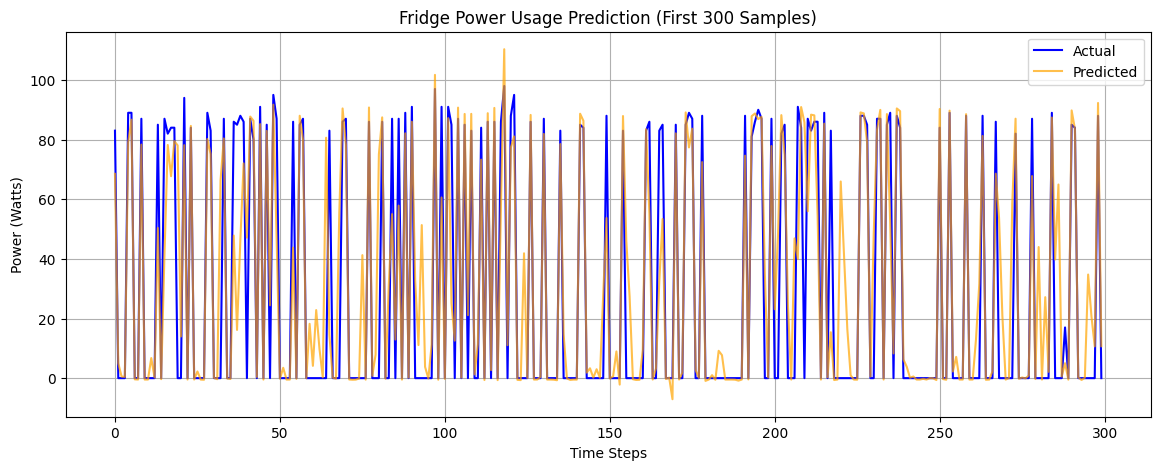

In [19]:
# Plot predictions vs actual
plt.figure(figsize=(14, 5))
plt.plot(actuals_inv[:300], label='Actual', color='blue')
plt.plot(predictions_inv[:300], label='Predicted', color='orange', alpha=0.7)
plt.title("Fridge Power Usage Prediction (First 300 Samples)")
plt.xlabel("Time Steps")
plt.ylabel("Power (Watts)")
plt.legend()
plt.grid(True)
plt.show()


In [20]:
# Save model weights
torch.save(model.state_dict(), 'best_lstm_transformer_final.pth')
